In [1]:
!pip install visualkeras
!pip install netron
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d423e09d7745075aa73dcd9342d8b01272a40e22e602e4444c8969a29deeed05
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
#ucitavanje biblioteka koje ce biti koriscene
import numpy as np
from numpy import asarray
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications import ResNet50V2
from keras.models import Model
from skimage.segmentation import mark_boundaries
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from keras.callbacks import EarlyStopping, ModelCheckpoint
import visualkeras
import os
import PIL
import tensorflow as tf
from keras.utils import to_categorical
import netron
import lime
from lime import lime_image
import matplotlib.cm as cm
from lime import submodular_pick
from IPython.display import Image, display
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
%cd "/content/gdrive/MyDrive/"

/content/gdrive/MyDrive


In [5]:
#provera da li se stvari izvrsavaju na GPU
#koriscena tf T4 graficka kartica
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10726751007361246098
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1949330147129182502
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
#deo sa ucitavanjem slika
batch_size = 64
#dimenzije slika
img_height = 224
img_width = 224
#ucitavanje trening skupa i skupa za validaciju
train_data, val_data= tf.keras.utils.image_dataset_from_directory(
    directory = 'vegetable_data',
    validation_split = 0.2,
    seed = 123,
    subset = "both",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
#imena klasa
class_names = train_data.class_names
print(f"\nImena klasa: {class_names}")
#provera oblika podataka
for batch_X, batch_y in train_data.take(1):
    print(batch_X.shape)
    print(batch_y.shape)
#znaci da imamo batch od po 64 slika, dimenzije su im 224x224, a imaju po 3 kanala

Found 14999 files belonging to 15 classes.
Using 12000 files for training.
Using 2999 files for validation.

Imena klasa: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
(64, 224, 224, 3)
(64,)


      class_name  count
0           Bean   1000
1   Bitter_Gourd   1000
2   Bottle_Gourd   1000
3        Brinjal   1000
4       Broccoli   1000
5        Cabbage   1000
6       Capsicum   1000
7         Carrot   1000
8    Cauliflower   1000
9       Cucumber    999
10        Papaya   1000
11        Potato   1000
12       Pumpkin   1000
13        Radish   1000
14        Tomato   1000


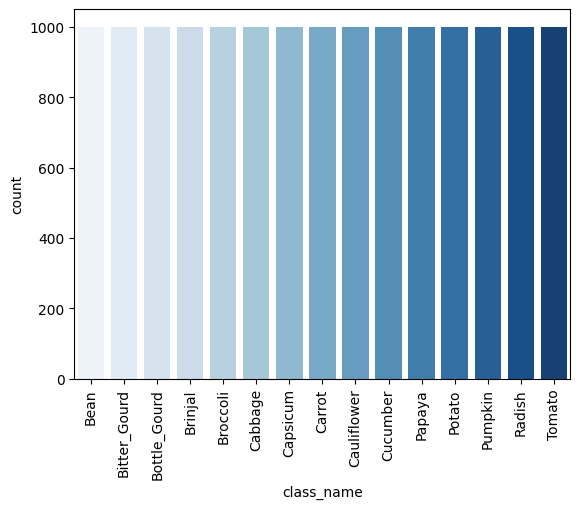

In [7]:
#pregled balansiranosti dataseta
folder_len = []
folder_name = []
folder = 'vegetable_data'
for root, dirs, files in os.walk(folder):
    folder_len.append(len(files))
folder_len.pop(0)
df = pd.DataFrame({"class_name": class_names, "count":folder_len})
print(df)
sns.barplot(x = 'class_name',
            y = 'count',
            data = df,
            palette = 'Blues')
plt.xticks(rotation=90)
plt.show()

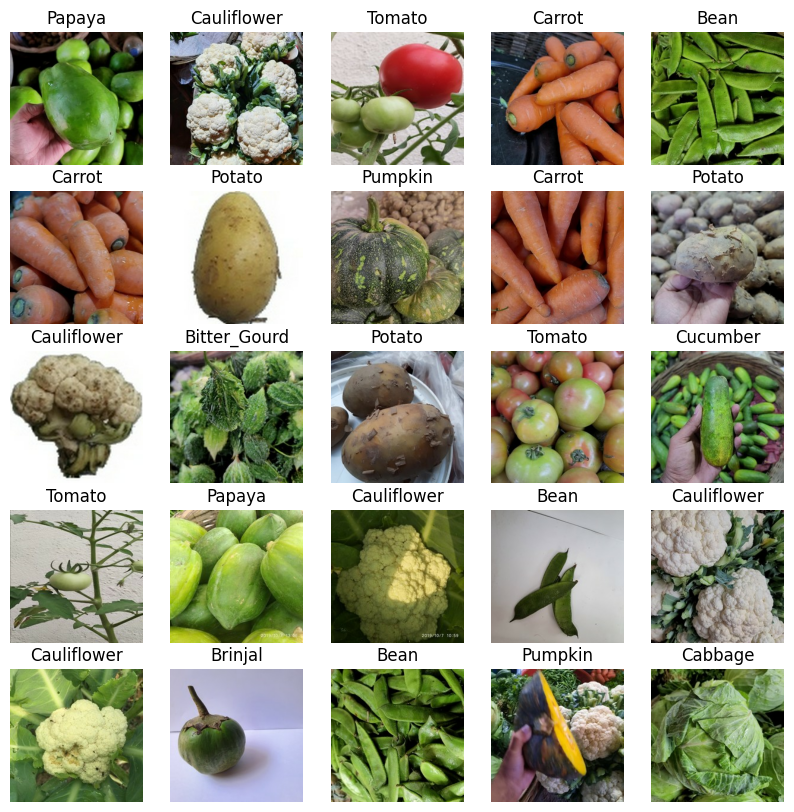

In [8]:
#vizuelizacija ucitanih podataka
plt.figure(figsize = (10,10))
for images, labels in train_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
#kreiranje sloja za augmentaciju slika
augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.2),
        layers.RandomBrightness(factor=0.2),
        layers.RandomFlip("horizontal_and_vertical"),
    ]
)
#kreiranje sloja za normalizaciju podataka
normalization = tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))

In [10]:
#definisanje callback-a
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=2),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

In [11]:
#kreiranje arhitekture CNN-a
num_classes = len(class_names)
model = Sequential([
  augmentation,
  normalization,
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])
#kompajliranje modela
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer = opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy'])

In [19]:
#treniranje modela
history = model.fit(
    train_data,
    validation_data = val_data,
    callbacks = callbacks,
    epochs = 10
)

Epoch 1/10
188/188 [==============================] - 38s 181ms/step - loss: 2.1920 - accuracy: 0.2624 - val_loss: 1.6490 - val_accuracy: 0.4318
Epoch 2/10
188/188 [==============================] - 35s 181ms/step - loss: 1.5742 - accuracy: 0.4587 - val_loss: 1.3871 - val_accuracy: 0.5138
Epoch 3/10
188/188 [==============================] - 35s 183ms/step - loss: 1.3323 - accuracy: 0.5370 - val_loss: 1.1566 - val_accuracy: 0.6015
Epoch 4/10
188/188 [==============================] - 34s 179ms/step - loss: 1.1555 - accuracy: 0.6012 - val_loss: 1.0793 - val_accuracy: 0.6252
Epoch 5/10
188/188 [==============================] - 34s 176ms/step - loss: 1.0267 - accuracy: 0.6475 - val_loss: 0.9172 - val_accuracy: 0.6672
Epoch 6/10
188/188 [==============================] - 38s 194ms/step - loss: 0.9343 - accuracy: 0.6801 - val_loss: 0.9109 - val_accuracy: 0.6752
Epoch 7/10
188/188 [==============================] - 34s 178ms/step - loss: 0.8470 - accuracy: 0.7065 - val_loss: 0.7732 - val_ac

In [12]:
#prikaz evaluacije modela - accuracy
def plot_accuracy():
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()


In [13]:
#prikaz evaluacije modela - loss
def plot_loss():
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()


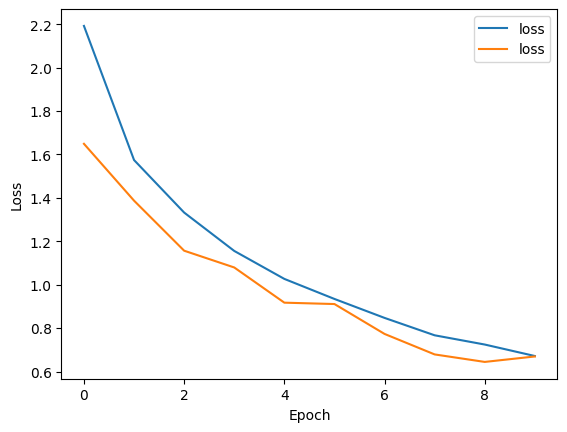

In [22]:
plot_loss()

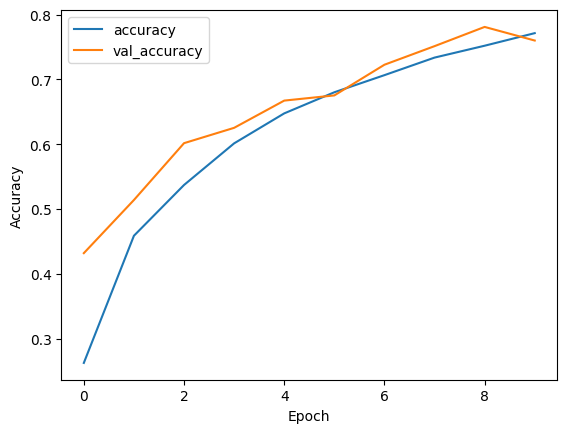

In [23]:
plot_accuracy()

In [24]:
#snimanje modela u fajl
model.summary()
model.save('custom_model.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

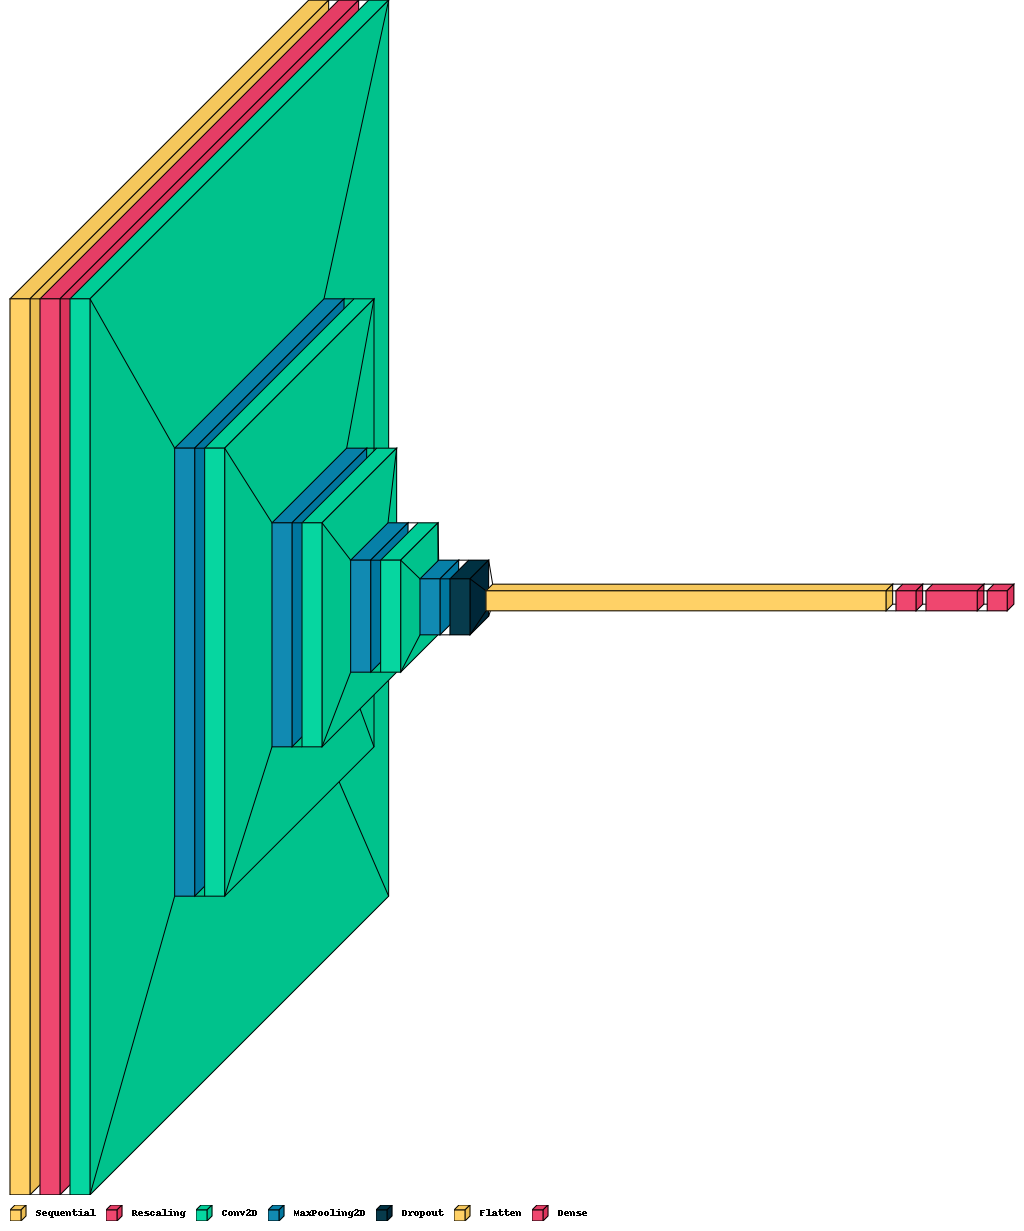

In [25]:
#vizuelizacija arhitekture koriscenjem visualkeras-a
visualkeras.layered_view(model, legend = True)

In [39]:
#vizuelizacija arhitekture mreze koriscenjem Netron-a
netron.start('custom_model.h5')

Serving 'custom_model.h5' at http://localhost:22768


('localhost', 22768)

In [14]:
#funkcija za odabir slike nad kojom ce se vrsiti explainability
def chose_image_to_explain(img_path):
    plt.figure(figsize = (5,5))
    img = tf.keras.utils.load_img(img_path,target_size= (224,224))
    img = asarray(img)
    plt.imshow(img)
    return img

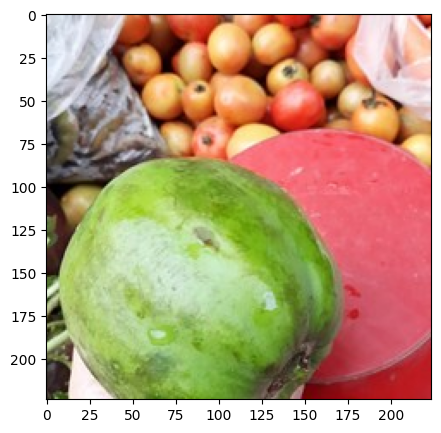

In [118]:
img = chose_image_to_explain('test//Papaya//1388.jpg')

In [16]:
#funkcija za ucitavanje modela i primenu LIME-a
def lime_explainer(model_name, img):
    model = keras.models.load_model(model_name)
    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(img,
                                      model.predict,
                                      top_labels = 5,
                                      hide_color = 0)
    return exp

In [119]:
exp = lime_explainer('custom_model.h5', img)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


In [18]:
#funkcija za prikaz predikcije explainer-a
def lime_explain_prediction(exp):
    print(exp.top_labels)
    vegetable_dict = {"vegetable": class_names}
    df = pd.DataFrame(vegetable_dict)
    print(df)
    print(f"The predicted class for this instance is: {df.iloc[exp.top_labels[0]]}")

In [120]:
lime_explain_prediction(exp)

[10, 6, 9, 0, 2]
       vegetable
0           Bean
1   Bitter_Gourd
2   Bottle_Gourd
3        Brinjal
4       Broccoli
5        Cabbage
6       Capsicum
7         Carrot
8    Cauliflower
9       Cucumber
10        Papaya
11        Potato
12       Pumpkin
13        Radish
14        Tomato
The predicted class for this instance is: vegetable    Papaya
Name: 10, dtype: object


In [81]:
#funkcija za vizuelizaciju koriscenjem LIME-a
def lime_explain_visualize(pos_only, hide_rest, no_of_feat, opt):
    fig, ax = plt.subplots()
    image, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only = pos_only, num_features = no_of_feat,hide_rest = hide_rest)
    temp_1, mask_1 = exp.get_image_and_mask(exp.top_labels[0], positive_only=not pos_only, num_features=no_of_feat, hide_rest=not hide_rest)
    return plt.imshow(mark_boundaries(image,mask).astype("uint8")) if opt else ax.imshow(mark_boundaries(temp_1, mask_1))

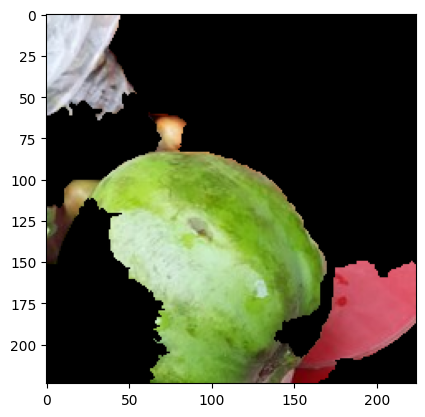

In [121]:
lime_explain_visualize(True, True, 10, 1)

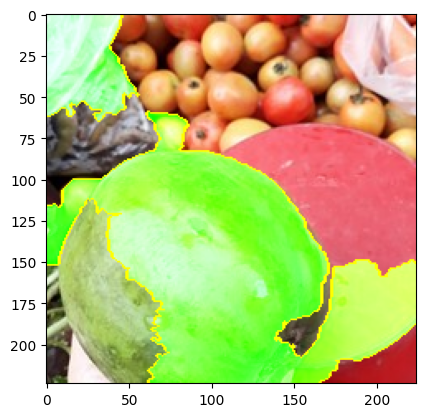

In [122]:
lime_explain_visualize(True, True, 10, 0)

In [123]:
#funkcija preuzeta sa linka iz keras dokumentacije: https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [124]:
image_file = 'test//Papaya//1388.jpg'
img = tf.keras.utils.load_img(image_file,target_size= (224,224,3))
img = asarray(img)
img = np.expand_dims(img, axis=0)

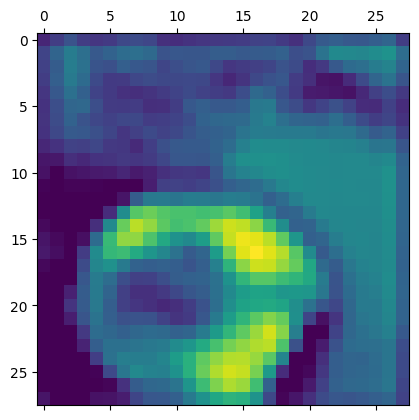

In [125]:
model = keras.models.load_model('custom_model.h5')
last_conv_name = 'conv2d_14'
heatmap = make_gradcam_heatmap(img, model, last_conv_name)
plt.matshow(heatmap)
plt.show()

In [126]:
#funkcija preuzeta sa istog linka iz keras dokumentacije
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))


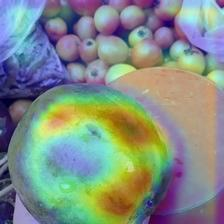

In [127]:
save_and_display_gradcam(image_file,heatmap)

In [60]:
vgg = VGG19(include_top = False,
                         weights = 'imagenet',
                         input_shape = (224,224,3))
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [61]:
#rad sa VGG19 modelom
vgg = VGG19(include_top = False,
                         weights = 'imagenet',
                         input_shape = (224,224,3))
fine_tune = 0
#zamrzavamo sve slojeve, nista ne treniramo ponovo
for layer in vgg.layers[-5:]:
    layer.trainable = False
top = vgg.output
top_model = Flatten()(top)
top_model = Dropout(0.25)(top_model)
output_layer = Dense(len(class_names), activation = 'softmax')(top_model)

new_model = Model(inputs = vgg.input, outputs = output_layer)
opt2 = keras.optimizers.RMSprop(learning_rate=0.1)
opt = keras.optimizers.Adam(learning_rate=0.0001)
new_model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
history = new_model.fit(
    train_data,
    validation_data = val_data,
    callbacks = callbacks,
    epochs = 10,
)

Epoch 1/10
188/188 [==============================] - 211s 1s/step - loss: 2.1670 - accuracy: 0.3364 - val_loss: 0.8364 - val_accuracy: 0.7346
Epoch 2/10
188/188 [==============================] - 209s 1s/step - loss: 0.6883 - accuracy: 0.7734 - val_loss: 0.4355 - val_accuracy: 0.8710
Epoch 3/10
188/188 [==============================] - 216s 1s/step - loss: 0.3235 - accuracy: 0.9008 - val_loss: 0.2122 - val_accuracy: 0.9363
Epoch 4/10
188/188 [==============================] - 207s 1s/step - loss: 0.2081 - accuracy: 0.9372 - val_loss: 0.1665 - val_accuracy: 0.9507
Epoch 5/10
188/188 [==============================] - 207s 1s/step - loss: 0.1240 - accuracy: 0.9607 - val_loss: 0.1035 - val_accuracy: 0.9707
Epoch 6/10
188/188 [==============================] - 211s 1s/step - loss: 0.1148 - accuracy: 0.9651 - val_loss: 0.0872 - val_accuracy: 0.9760
Epoch 7/10
188/188 [==============================] - 212s 1s/step - loss: 0.0722 - accuracy: 0.9775 - val_loss: 0.0736 - val_accuracy: 0.9783

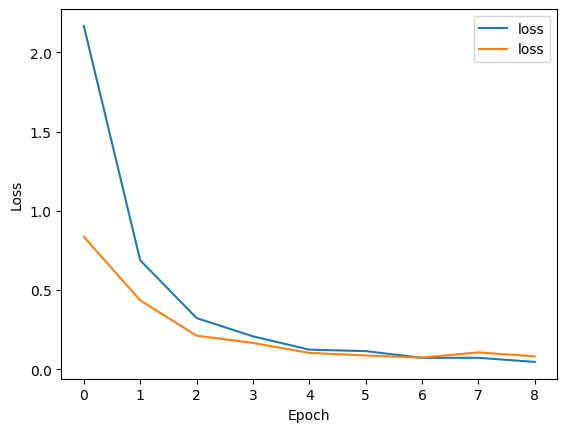

In [62]:
plot_loss()

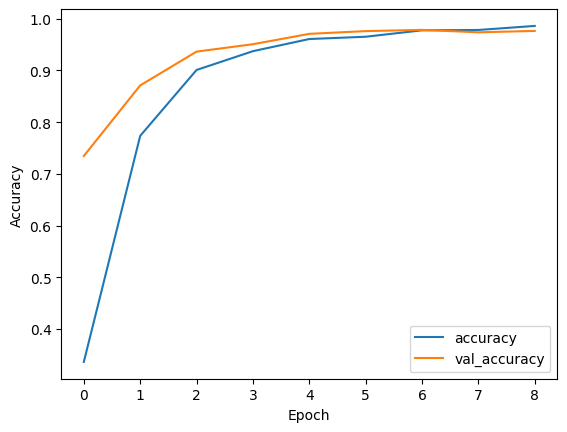

In [63]:
plot_accuracy()

In [64]:
#cuvanje VGG modela nakon fine tunning-a
new_model.save('vgg19_model.h5')

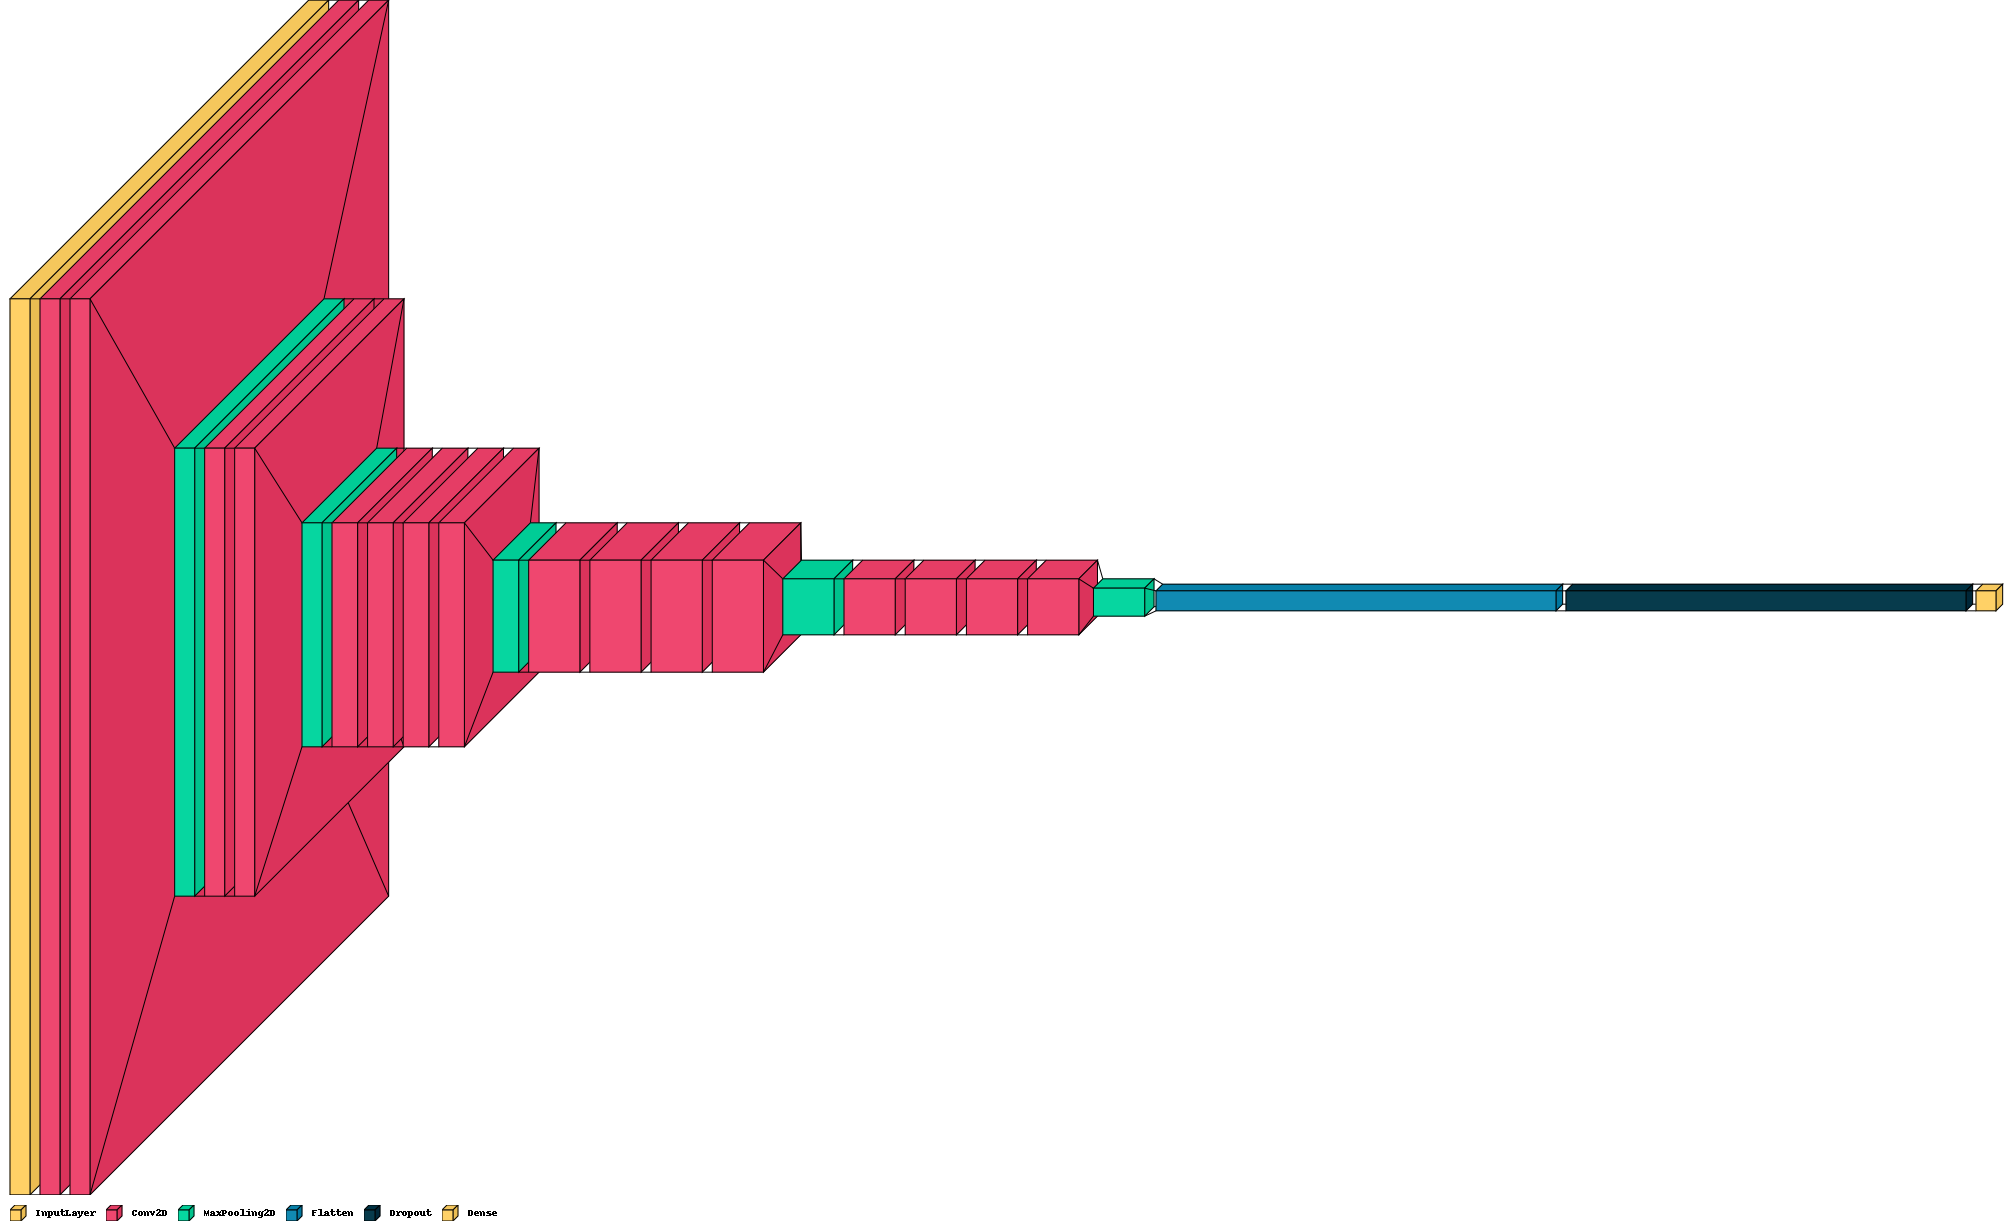

In [65]:
#vizuelizacija arhitekture fine tjunovanog modela VGG19 koriscenjem visualkeras-a
visualkeras.layered_view(new_model, legend = True)

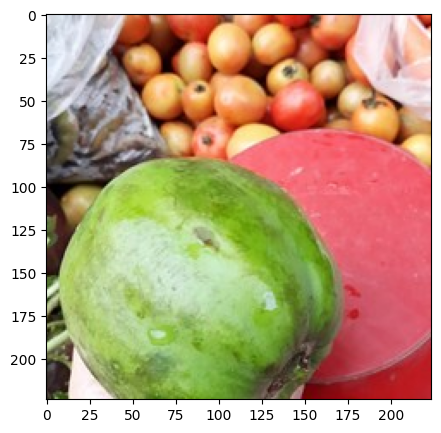

In [128]:
img = chose_image_to_explain('test//Papaya//1388.jpg')

In [129]:
#ucitavanje modela i primena LIME-ax
exp = lime_explainer('vgg19_model.h5', img)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


In [130]:
lime_explain_prediction(exp)

[10, 6, 14, 3, 2]
       vegetable
0           Bean
1   Bitter_Gourd
2   Bottle_Gourd
3        Brinjal
4       Broccoli
5        Cabbage
6       Capsicum
7         Carrot
8    Cauliflower
9       Cucumber
10        Papaya
11        Potato
12       Pumpkin
13        Radish
14        Tomato
The predicted class for this instance is: vegetable    Papaya
Name: 10, dtype: object


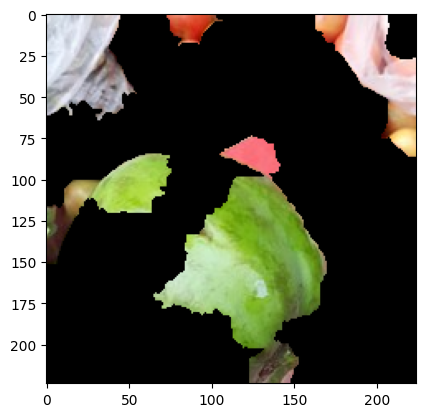

In [131]:
lime_explain_visualize(True, True, 10, 1)

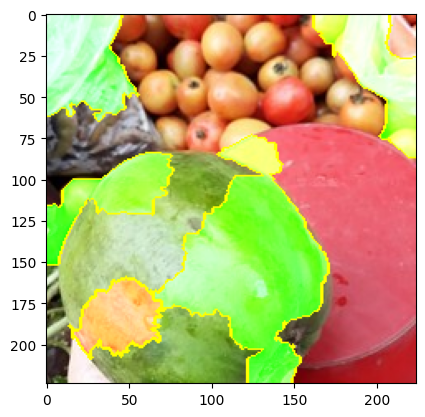

In [132]:
lime_explain_visualize(True, True, 10, 0)

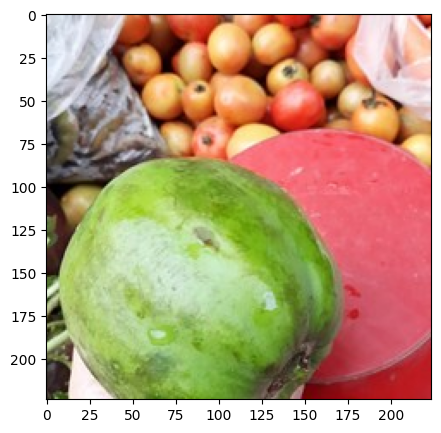

In [133]:
img = chose_image_to_explain('test//Papaya//1388.jpg')
img = tf.keras.utils.load_img(image_file,target_size= (224,224,3))
img = asarray(img)
img = np.expand_dims(img, axis=0)

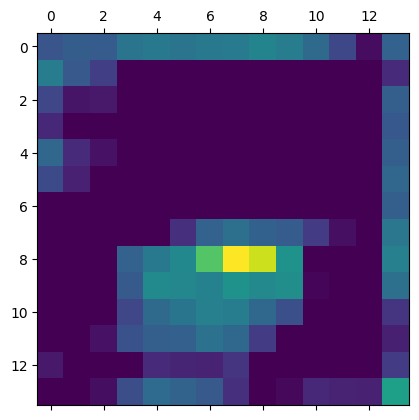

In [134]:
model = keras.models.load_model('vgg19_model.h5')
last_conv_name = 'block5_conv4'
heatmap = make_gradcam_heatmap(img, model, last_conv_name)
plt.matshow(heatmap)
plt.show()

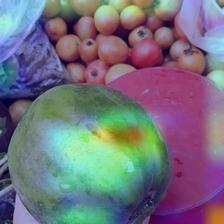

In [135]:
save_and_display_gradcam(image_file,heatmap)